# Explore _in vitro_ development with PySCN
This tutorial walks through typical analysis steps for the analysis of engineered cell populations. We will first use PySCN to figure out the extent to which mouse embryonic stem cells prompted to form 'gastruoilds' approximate the transcriptional state of their natural counterparts from the mouse embryo. Then, we will see how a variation on the gastruloid protocol impacts their transcriptional fidelity. Finally, we will end by identifying pathways that distguish 'good' engineered cells from less good ones. 

## Data

### Training data
The training data is a subset of the mouse gastrulation atlas described in [Pijuan-Sala et al Nature 2019](https://www.nature.com/articles/s41586-019-0933-9). We have reduced the size of this dataset to make running this tutorial more accessible. We have also re-annotated the cell lineages based on recent spatial transcriptomics studies of mouse gastrulation (see [Lohoff et al 2021](https://www.nature.com/articles/s41587-021-01006-2) and [Kumar et al 2023](https://www.nature.com/articles/s41588-023-01435-6)). 

- You can download the training data from [here](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/training/adMouseAtlas_demo_121823.h5ad)
- There are 18,023 cells
- 27,636 genes
- 25 cell types or lineages
- Sampled from E7.0 to E8.5

### Query data
The cells that we will examine are derived via differentiation of mouse embryonic stem cells (mESCs) in the form of gastruloids. There are two conditions here, one is standard gastruloid formation (standard), and the second is gastruloid formation from a mixture of mESCs and extraembryonic endoderm (XEN) cells. This second group is referred to as XEG. The data were generated by the Semrau lab and are described in [Bérenger-Currias et al 2022](https://pubmed.ncbi.nlm.nih.gov/35707767/). There are replicates for each condition.

- Raw data in H5ad form:
    - [Standard 1](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/query/ad_Standard_1_GSM4205743.h5ad)
    - [Standard 2](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/query/ad_Standard_2_GSM4205744.h5ad)
    - [XEG 1](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/query/ad_XEG_1_GSM4205746.h5ad)
    - [XEG 2](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/query/ad_XEG_2_GSM4205747.h5ad)
- Or, you can fetch the data in its original form from GEO [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE141530)



## Load packages

In [1]:
import scanpy as sc
from joblib import dump, load
import numpy as np
import pandas as pd
import pySingleCellNet as pySCN
import matplotlib.pyplot as plt
import seaborn as sns
import anndata


/opt/homebrew/Caskroom/miniforge/base/envs/pyscn_v3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load training data and query data

In [2]:
adAtlas = sc.read_h5ad("adMouseAtlas_demo_121823.h5ad")
adGastruloid = sc.read_h5ad("ad_Standard_1_GSM4205743.h5ad")
adXEG = sc.read_h5ad("ad_XEG_1_GSM4205746.h5ad")

## Limit to genes shared in both data sets

In [3]:
pySCN.limit_anndata_to_common_genes([adAtlas, adGastruloid, adXEG])

## Split up training data, and then train classifier

First, we will split the reference data into the training set made up of equal numbers of cells per cell type, and a held out data set.

In [4]:
adTrain, adHeldOut = pySCN.splitCommonAnnData(adAtlas, ncells=200,dLevel="celltype")
clf = pySCN.scn_train(adTrain, dLevel = 'celltype', nTopGenes = 25, nTopGenePairs = 25, nRand = 200, nTrees = 1000, stratify=False, propOther=0.50)


Meso.Mesenchyme : 
420
Meso.Nascent : 
1157
Meso.Somite : 
977
Endo.Gut : 
433
Ecto.N.Crest : 
518
Meso.HE.Progenitor : 
663
Meso.Presomitic : 
671
Meso.Allantois : 
699
Node_Notochord : 
589
Endo.Visceral : 
527
Anterior.PS : 
800
Meso.LPM : 
566
NMP : 
1248
Endo.Parietal : 
263
Ecto.Surface : 
557
Meso.Angioblast : 
828
Ecto.Nascent.CN : 
1202
Ecto.Neural : 
1063
Epiblast_Ectoderm : 
932
Meso.Blood.Progenitor : 
829
Primordial.GC : 
445
Ecto.Extra : 
500
Meso.Cardio : 
548
Meso.Erythroid : 
1115
Endo.Extra : 
473
HVG
Matrix normalized
There are  398  classification genes

Anterior.PS
Ecto.Extra
Ecto.N.Crest
Ecto.Nascent.CN
Ecto.Neural
Ecto.Surface
Endo.Extra
Endo.Gut
Endo.Parietal
Endo.Visceral
Epiblast_Ectoderm
Meso.Allantois
Meso.Angioblast
Meso.Blood.Progenitor
Meso.Cardio
Meso.Erythroid
Meso.HE.Progenitor
Meso.LPM
Meso.Mesenchyme
Meso.Nascent
Meso.Presomitic
Meso.Somite
NMP
Node_Notochord
Primordial.GC
There are 8137 top gene pairs

Finished pair transforming the data



Classify heldout data and visualize.

... storing 'SCN_class' as categorical


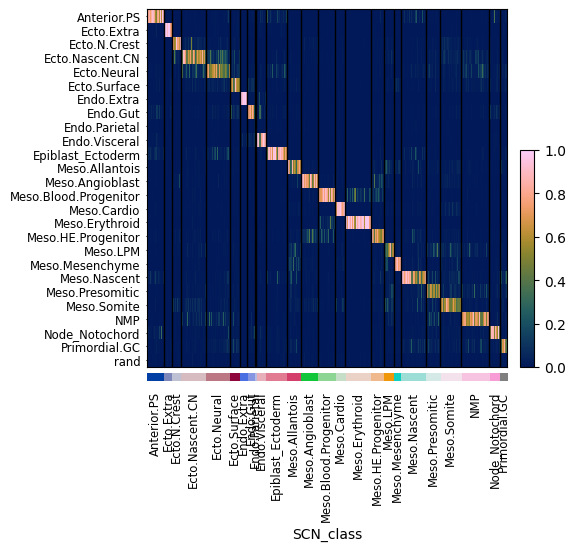

In [5]:
pySCN.scn_classify(adHeldOut, clf, nrand = 0)
pySCN.heatmap_scores(adHeldOut, groupby='SCN_class')

## Assess performance on heldout data

0.883248730964467
0.8706199460916442
0.8872497365648051
0.9241527703066165
0.9710540688148553
0.828786999419617
0.8932038834951457
0.901010101010101
0.9278752436647174
0.9430676490288011
0.9274900398406374
0.9568
0.9489291598023064
0.9368836291913214
0.8989247311827957
0.9580052493438321
0.9715099715099715
0.9756097560975611
0.9638932496075353
0.9966777408637874
0.9908925318761385
0.8854961832061068
0.8879492600422833
0.9103247697527872
0.9767441860465117


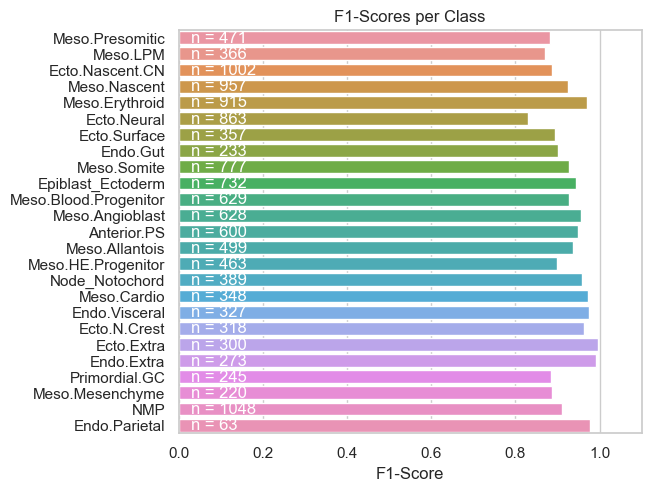

In [6]:
pySCN.barplot_classifier_f1(adHeldOut, ground_truth="celltype", class_prediction="SCN_class")

## Now analyze the query data

... storing 'SCN_class' as categorical


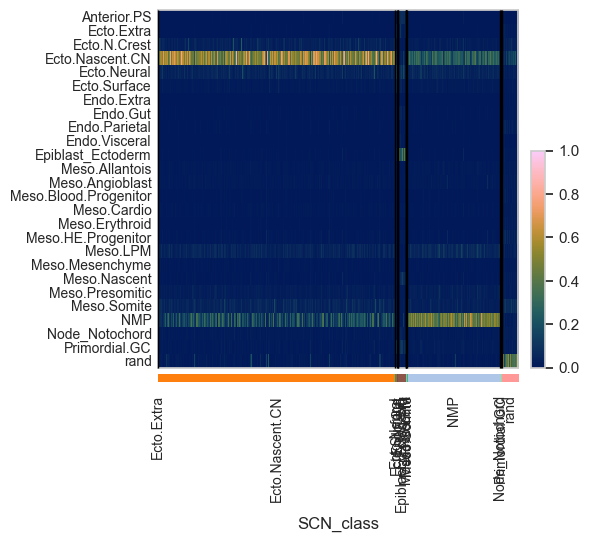

In [8]:
pySCN.scn_classify(adGastruloid, clf, nrand = 0)
pySCN.heatmap_scores(adGastruloid, groupby='SCN_class')

We can embed the query data and see how SCN classification and SCN scores are distributed across clusters

... storing 'SCN_class' as categorical


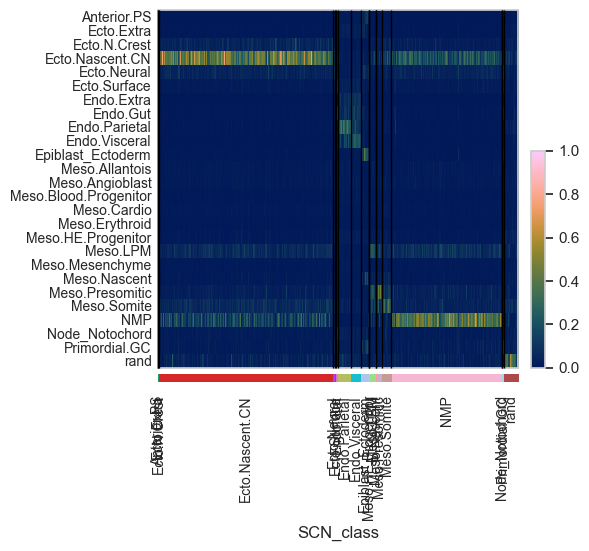

In [9]:
pySCN.scn_classify(adXEG, clf, nrand = 0)
pySCN.heatmap_scores(adXEG, groupby='SCN_class')

## Empirical categorization of classification calls
Classification calls are based on the category with the highest SCN score, which is just the proportion of decision trees in the random forest that vote for the class. In some instances, it is useful to apply a more stingent threshold for making a classification call. For example, when one or more categories have scores nearly as high as that of the maximum. We can empirically select cell-type specific thresholds that, when applied to held out data, results a given False Negative Rate (FNR). pySCN.comp\_ct\_thresh() will compute these values:

In [11]:
tThrs_val_05 = pySCN.comp_ct_thresh(adHeldOut, 0.05)
tThrs_val_05

Anterior.PS
Ecto.Extra
Ecto.N.Crest
Ecto.Nascent.CN
Ecto.Neural
Ecto.Surface
Endo.Extra
Endo.Gut
Endo.Parietal
Endo.Visceral
Epiblast_Ectoderm
Meso.Allantois
Meso.Angioblast
Meso.Blood.Progenitor
Meso.Cardio
Meso.Erythroid
Meso.HE.Progenitor
Meso.LPM
Meso.Mesenchyme
Meso.Nascent
Meso.Presomitic
Meso.Somite
NMP
Node_Notochord
Primordial.GC


0
Anterior.PS            0.41130
Ecto.Extra             0.70425
Ecto.N.Crest           0.43280
Ecto.Nascent.CN        0.33350
Ecto.Neural            0.29300
Ecto.Surface           0.28560
Endo.Extra             0.74425
Endo.Gut               0.31005
Endo.Parietal          0.52250
Endo.Visceral          0.47080
Epiblast_Ectoderm      0.38100
Meso.Allantois         0.26370
Meso.Angioblast        0.39020
Meso.Blood.Progenitor  0.49325
Meso.Cardio            0.42650
Meso.Erythroid         0.56400
Meso.HE.Progenitor     0.32920
Meso.LPM               0.27975
Meso.Mesenchyme        0.28080
Meso.Nascent           0.27305
Meso.Presomitic        0.29130
Meso.Somite            0.26310
NMP                    0.34770
Node_Notochord         0.32180
Primordial.GC          0.27090

We can pass them to pySCN.class\_by\_threshold, which will make new classification calls and add them to anndata.obs\['SCN\_class\_emp'\]. It is possible that more than one class receives a score that exceeds its respective threshold. In these cases, class\_by\_threshold sets .obs\['SCN\_class\_emp'\] to the combinded class labels. .obs\['SCN\_class\_emp'\]. \`class\_by\_threshold\` also adds .obs\['SCN\_class\_type'\], which is one of 'Singlular', 'Hybrid', or 'None' indicating the number of categories passing their respective thresholds.

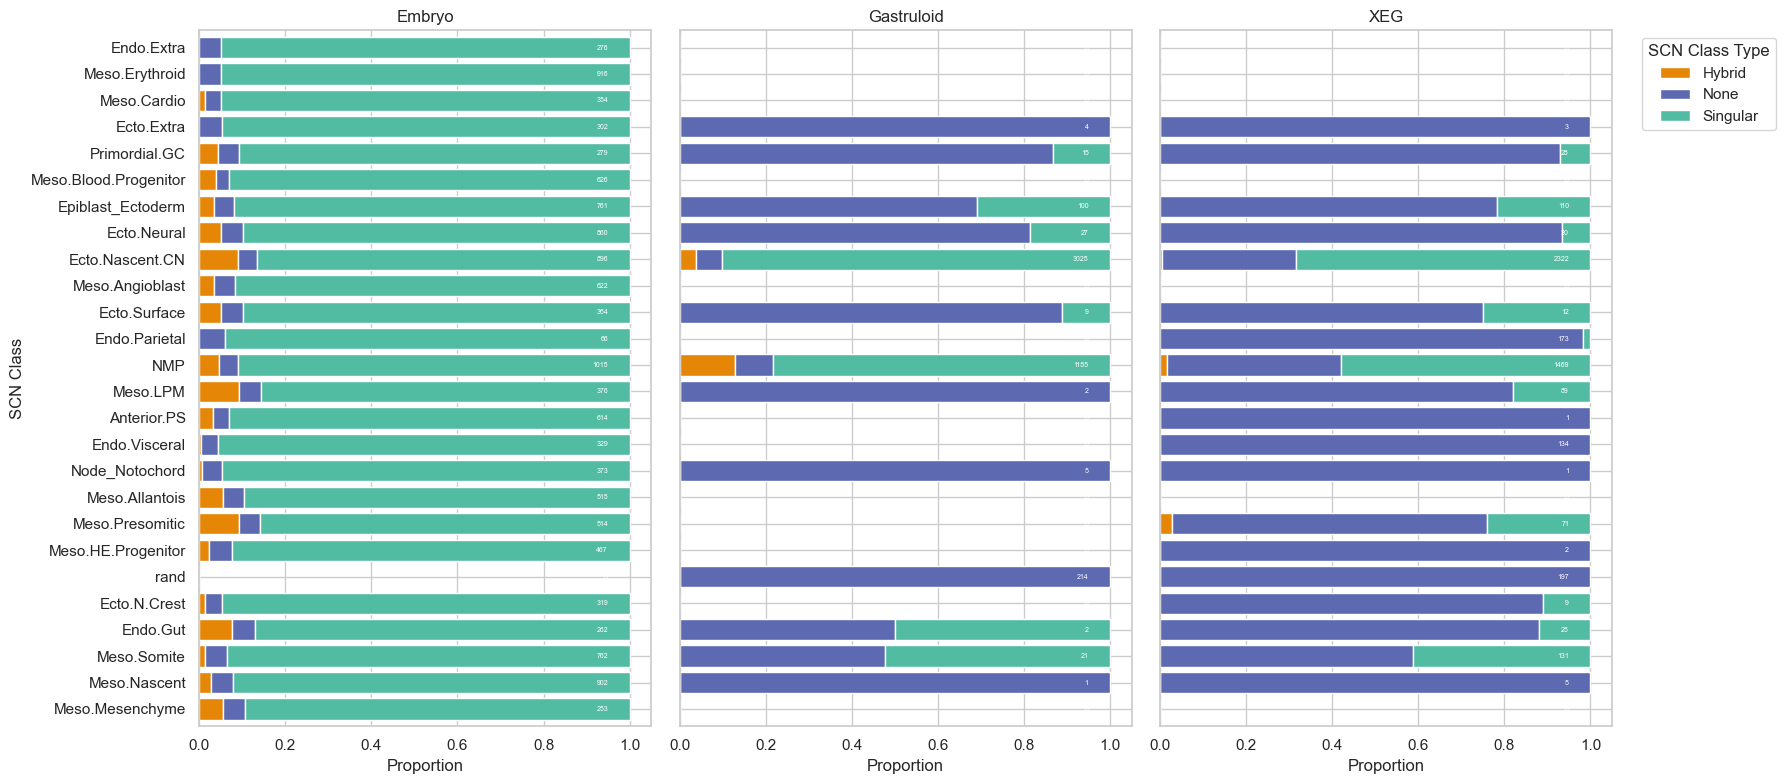

In [12]:
pySCN.class_by_threshold(adHeldOut, tThrs_val_05)
pySCN.class_by_threshold(adGastruloid, tThrs_val_05)
pySCN.class_by_threshold(adXEG, tThrs_val_05)
aplot = pySCN.barplot_class_proportions_list([adHeldOut, adGastruloid, adXEG], titles=['Embryo', 'Gastruloid', 'XEG'], bar_height=0.8)
aplot.show()

Let's focus on the cell types that are most abundant in the engineered populations.

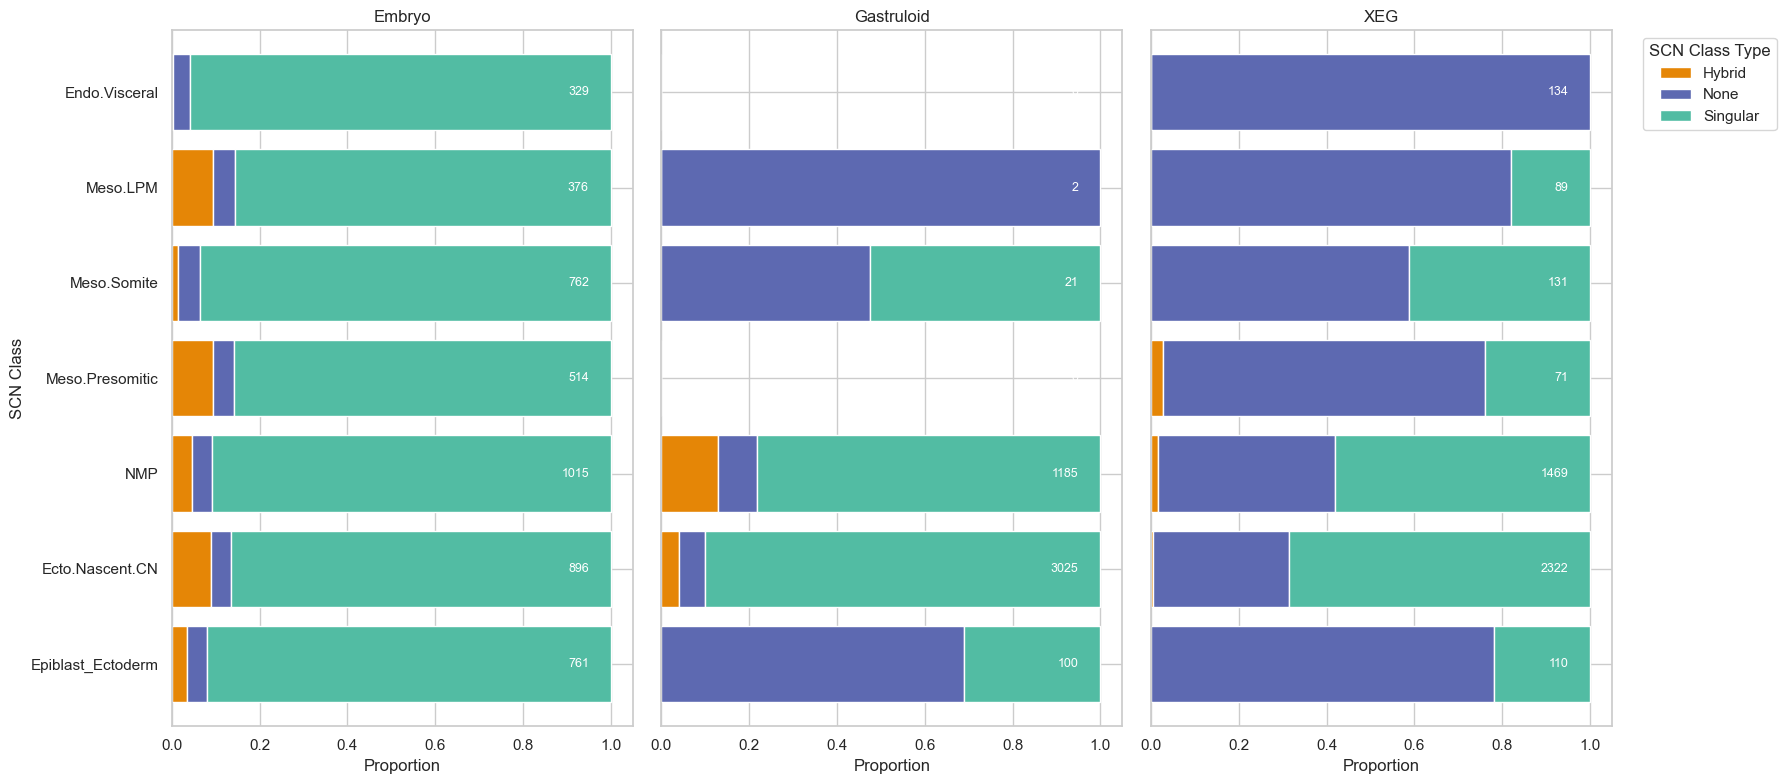

In [13]:
cellgrps = ["Epiblast_Ectoderm", "Ecto.Nascent.CN", "NMP", "Meso.Presomitic", "Meso.Somite", "Meso.LPM", "Endo.Visceral"]
aplot = pySCN.barplot_class_proportions_list([adHeldOut, adGastruloid, adXEG], titles=['Embryo', 'Gastruloid', 'XEG'], scn_classes_to_display=cellgrps, bar_height=0.8)
aplot.show()

## Gene set enrichment analysis
What pathways distinguish the Gastruloid cells from the XEGs? Run GSEA on these samples after integrating them to answer this question. Note that this analysis uses [GSEAPY](https://gseapy.readthedocs.io/en/latest/index.html). 

Here are some useful genesets:
- [Signaling pathway effector targets](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/genesets/Signaling_Targets_ChipAtlas_102222.gmt) that [we previously curated](https://pubmed.ncbi.nlm.nih.gov/35090587/) from [Chip-Atlas](https://chip-atlas.org/)
- Mouse [MSigDB Hallmarks](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/genesets/mh.all.v2023.2.Mm.symbols.gmt) as described [here](https://www.gsea-msigdb.org/gsea/msigdb/mouse/collections.jsp)
- [Signaling pathways in development](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/genesets/SIGNALING_v7.4_101322.gmt)
- [GOBP development subset](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/genesets/GOBP_Development_v7.4_101322.gmt)


In [14]:
signaling_targets = pySCN.read_gmt("Signaling_Targets_ChipAtlas_102222.gmt")
hallmarks = pySCN.read_gmt("mh.all.v2023.2.Mm.symbols.gmt")

Set commond paramaters across subsequent GSEA analyses

In [15]:
p_num = 1e3
fdr_thresh = 0.1

Define the groups of cells to compare.

In [16]:
cellgrps = ["Epiblast_Ectoderm", "Ecto.Nascent.CN", "NMP", "Meso.Presomitic", "Meso.Somite"]

Compare standard gastruloids to XEG

In [17]:
comp_grps = ["Gastruloid","XEG"]
# combine the raw data from each annData
adComb = pySCN.combine_adatas_for_deg(adatas = [adGastruloid, adXEG], sample_obsvals = comp_grps, cellgrp_obsnames=['SCN_class', 'SCN_class'])
# remove any Mt- and ribosomal genes, and compute some basic QC metrics
adComb = pySCN.mito_rib(adComb, species='MM', clean=True)
# Basic read depth normalization and log transformation
sc.pp.normalize_total(adComb, 1e4)
sc.pp.log1p(adComb)
# Differential gene expression. This calls the scanpy function tl.rank.genes.groups
deg_res = pySCN.deg(adComb, sample_obsvals=comp_grps, limitto_obsvals=cellgrps,ncells_per_sample = 10, test_name='t-test')

... storing 'SCN_class' as categorical
... storing 'SCN_class_emp' as categorical
... storing 'SCN_class_type' as categorical
... storing 'comb_sampname' as categorical
... storing 'comb_cellgrp' as categorical
... storing 'SCN_class' as categorical
... storing 'SCN_class_emp' as categorical
... storing 'SCN_class_type' as categorical
... storing 'comb_sampname' as categorical
... storing 'comb_cellgrp' as categorical


cell group: Epiblast_Ectoderm
cell group: Ecto.Nascent.CN


... storing 'SCN_class' as categorical
... storing 'SCN_class_emp' as categorical
... storing 'SCN_class_type' as categorical
... storing 'comb_sampname' as categorical
... storing 'comb_cellgrp' as categorical
... storing 'SCN_class' as categorical
... storing 'SCN_class_emp' as categorical
... storing 'SCN_class_type' as categorical
... storing 'comb_sampname' as categorical
... storing 'comb_cellgrp' as categorical


cell group: NMP
cell group: Meso.Presomitic
cell group: Meso.Somite


Now use GSEAPY to perform GSEA

In [18]:
gs_name = 'hallmarks'
gsea_res = pySCN.gsea_on_deg(deg_res['geneTab_dict'], gs_name, genesets = hallmarks, permutation_num = p_num)

2023-12-18 15:33:10,959 [WARNING] Duplicated values found in preranked stats: 49.47% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-12-18 15:33:13,042 [WARNING] Duplicated values found in preranked stats: 38.84% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-12-18 15:33:15,062 [WARNING] Duplicated values found in preranked stats: 41.40% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-12-18 15:33:17,663 [WARNING] Duplicated values found in preranked stats: 60.66% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Now gather and visualize the results as a heatmap. Only significant enrichments will be colored. Gene sets that are significantly enriched in Standard will be colored red, those that are enriched in XEG will be colored blue. This coloring is determined by the order of the groups as defined above in `comp_grps`.

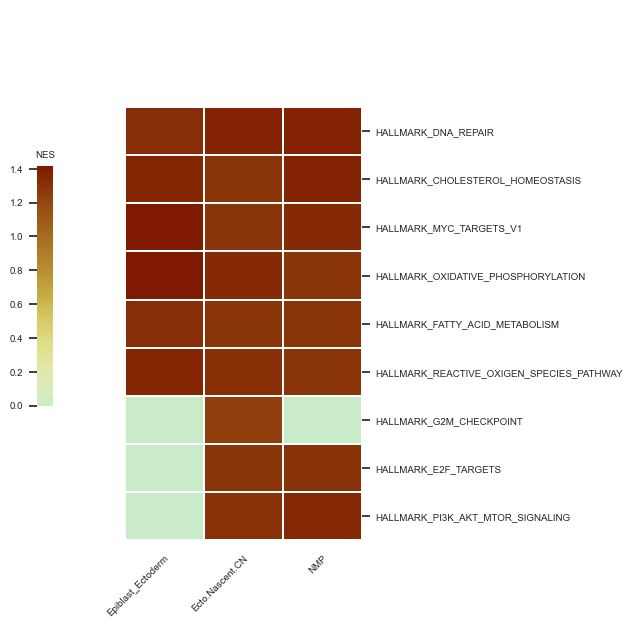

In [19]:
x = pySCN.collect_gsea_results_from_dict(gsea_res, fdr_thresh)
plt.rcParams['figure.constrained_layout.use'] = False
pySCN.heatmap_gsea(x, clean_signatures = True, clean_cells=True)

Now look at Signaling pathway targets

2023-12-18 15:36:04,899 [WARNING] Duplicated values found in preranked stats: 49.47% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-12-18 15:36:06,255 [WARNING] Duplicated values found in preranked stats: 38.84% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-12-18 15:36:07,602 [WARNING] Duplicated values found in preranked stats: 41.40% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-12-18 15:36:08,945 [WARNING] Duplicated values found in preranked stats: 60.66% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


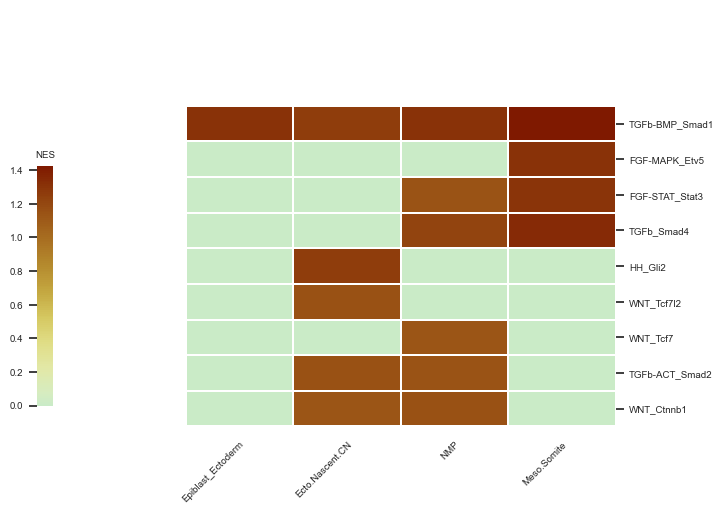

In [20]:
gs_name = 'signaling_targets'
gsea_res = pySCN.gsea_on_deg(deg_res['geneTab_dict'], gs_name, genesets = signaling_targets, permutation_num = p_num)
x = pySCN.collect_gsea_results_from_dict(gsea_res, fdr_thresh)
plt.rcParams['figure.constrained_layout.use'] = False
pySCN.heatmap_gsea(x, clean_signatures = True, clean_cells=True)

Note that the HH enrichment is consistent with higher levels of ventralization in gastruloids that were discussed in [Bérenger-Currias et al 2022](https://pubmed.ncbi.nlm.nih.gov/35707767/).

There is lots more to explore:
- Are the classification results reproducible in the replicates?
- For any given cell type, what pathways (if any) distinguish the 'Singular' cells across conditions?
- And what disintguishes the 'Singular' engineered cells from the 'Singluar' embryo cells?
- What is the nature of the 'None' cells in the embryo?
- Are the commonalities across the 'None' cells in terms of gene signatures or QC metrics?